# Milestone 1 Work

## Table of Contents

1. API Code for accessing genre of movie and poster path [Link](#section1)
2. List of 10 most popular TMDb movies and genres [Link](#section2)
3. Comments on challenges for predicting movie genre and how we'll address [Link](#section3)
4. Code and Visualization of movie genre pairs:
    - TMDb [Link](#section4a)
    - IMDb (see attached pdf)
5. EDA and sketches of visualizations: [Link](#section5a)
6. List of questions we're interested in answering  [Link](#section6)
7. (Extra) Unsupervised learning [Link](#section7)
8. (Extra) Supervised Learning (predict genre from title using bag of words and Naive Bayes and SVM models) [Link](#section8)



API KEY: ae89b22675ec02f644309a2de249121f

Install the "tmdbsimple" package: https://pypi.python.org/pypi/tmdbsimple

        `pip install tmdbsimple`
        
tmdbsimple is a wrapper for the TMDB API, providing python functions that perform some of the basic API requests. 

In [2]:
import tmdbsimple as tmdb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib2
import imdb
import time
import numpy as np
import csv
%matplotlib inline

In [3]:
tmdb.API_KEY = 'ae89b22675ec02f644309a2de249121f'

<a id='section1'><a\>

# Search for a movie, get its genre and poster

In [65]:
# Search for a movie by its title
search = tmdb.Search()
response = search.movie(query='The Princess Bride')
s = search.results[0]

ia = imdb.IMDb()
s_result = ia.search_movie('The Princess Bride')
s2 = ia.get_movie(s_result[0].movieID)

In [66]:
# Grab info from the search result
print "TMDb info for " + "The Princess Bride - ID:", s['id'], ", Genre IDs:", s['genre_ids']
print "IMDb info for " + "The Princess Bride - ID:", s_result[0].movieID

TMDb info for The Princess Bride - ID: 2493 , Genre IDs: [12, 10751, 14, 35, 10749]
IMDb info for The Princess Bride - ID: 0093779


In [68]:
# Get the genres, and the poster url
movie = tmdb.Movies(s['id']).info()
genres = movie['genres']
print [str(i["name"]) for i in genres]

poster_url = movie['poster_path']

['Adventure', 'Family', 'Fantasy', 'Comedy', 'Romance']


In [33]:
#get genres from IMDb 
[str(i) for i in s2.get('genres')]

['Adventure', 'Family', 'Fantasy', 'Romance']

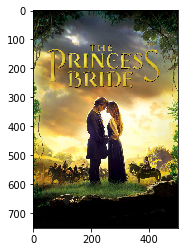

In [53]:
# Get the poster by its url and display it
img_url = 'https://image.tmdb.org/t/p/w500' + poster_url
img=plt.imread(urllib2.urlopen(img_url), format='jpeg')
plt.imshow(img)

<a id='section2'><a\>

# Get the top 10 most popular movies and their genres

In [ ]:
movies = tmdb.Movies().popular()['results']
top10 = movies[:10]

In [55]:
genres = tmdb.Genres().list()
for movie in top10:
    m = tmdb.Movies(movie['id']).info()
    genre_names = ' '.join([d['name'] for d in m['genres']])
    print movie['title'],":",genre_names

Beauty and the Beast : Fantasy Music Romance
Logan : Action Drama Science Fiction
Sing : Animation Comedy Drama Family Music
Jurassic World : Action Adventure Science Fiction Thriller
Fantastic Beasts and Where to Find Them : Adventure Action Fantasy
Finding Dory : Adventure Animation Comedy Family
Interstellar : Adventure Drama Science Fiction
Mad Max: Fury Road : Action Adventure Science Fiction Thriller
Rogue One: A Star Wars Story : Action Drama Science Fiction War
Split : Horror Thriller


<a id='section3'><a\>

# Comments on Genre Challenges

The problem lies in the inconsistencies between the two databases in regard to movie genre as well as their being multiple genres per movie. To address this problem, we anticipate performing a multi-label classification problem. Each movie will be assigned the genres that agree between the two databases (care will be taken that Sci-fi in IMDb and Science Fiction in TMDb are considered equaivalent, for example) - so we will use the intersect of the genre lists of TMDb and IMDb. 

# Exploratory Data Analysis

<a id='section5a'><a\>

## Sketches of Visualizations (also in attached PDF)

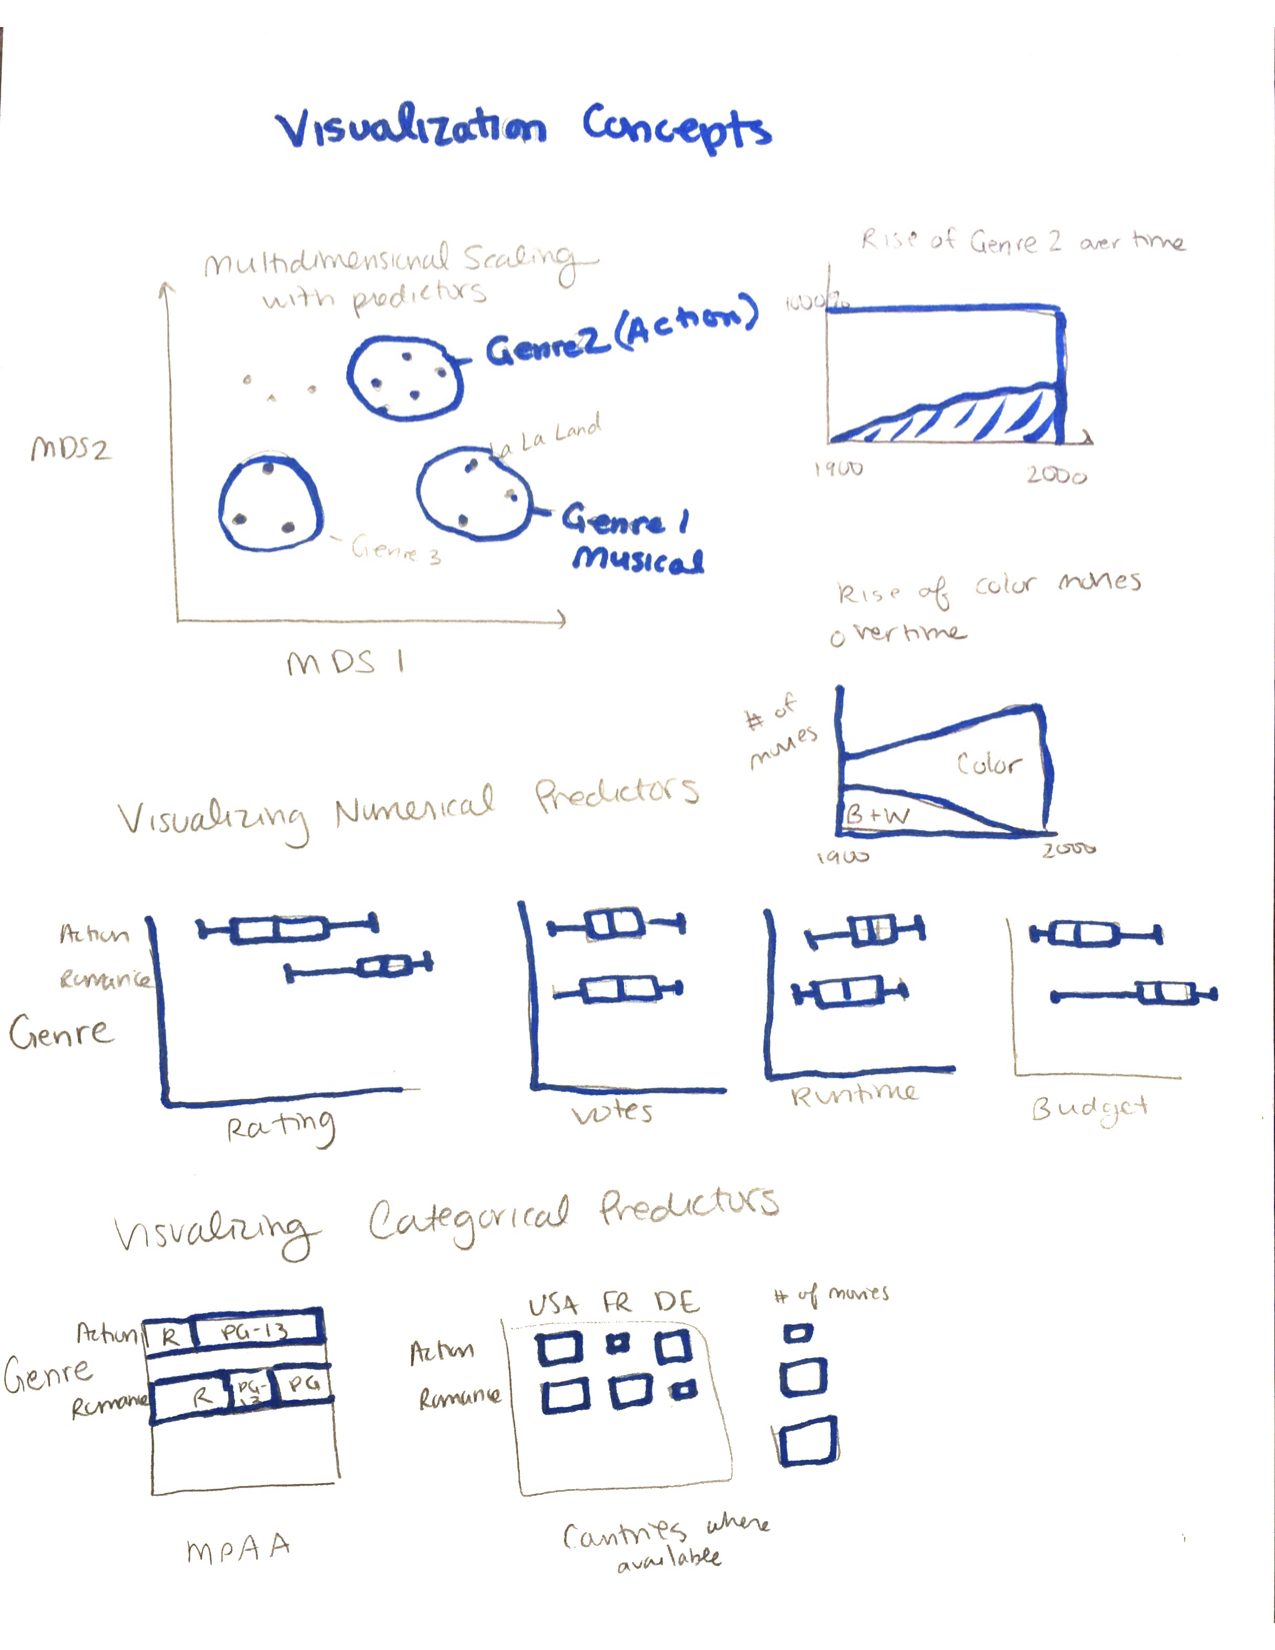

In [2]:
import os
from IPython.display import display, Image
names = [f for f in os.listdir('../CS109B_FinalProject') if f.endswith('.png')]
Image('../CS109B_FinalProject/' + names[0], width=100)

## TMDb EDA

There are currently 450259 movie IDs in the TMDb database (some are for movies that have since been deleted though). For EDA we take a random subset of 25,000 ids and exclude the IDs that correspond to deleted movies, bringing us to 13,320 movies. Finally, we ignore any movies without corresponding IMDb data, bringing us to just shy of 10,000 movies for our sample (9969 to be exact). 

In [4]:
import multiprocessing 
import random 

In [15]:
# get movie, genre pairs from TMDb
latest_id = tmdb.Movies().latest()['id']

def worker(i):
    try:
        movie = tmdb.Movies(i).info()
    except:
        movie = ""
    return [i, movie]

ids = list(range(1,latest_id))
random.shuffle(ids)
ids = ids[1:25000] #take random sample of 25,000 IDs 

p = multiprocessing.Pool()
ans = p.map(worker,ids)

global movie_dictionary 
movie_dictionary = {}
for i in ans:
    if i[1]: #only add the non-deleted movies to movie dictionary
        movie_dictionary[i[0]] = i[1] 


In [35]:
print "Number of movies in sample:",len(movie_dictionary)

Number of movies in sample: 13320


In [104]:
#write the movie information to a file
import csv
with open('movie_dict.csv','wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in movie_dictionary.items():
        ln = [key]
        for k, v in value.items():
            ln.append(k)
            try:
                ln.append(v.encode('utf-8'))
            except:
                ln.append(v)
        writer.writerow(ln)

In [107]:
#determine movies with an IMDb equivalent and write the IMDb_id and title to one file and 
#the subset of movie information (now our "EDA movie sample") to another

with open('EDA_movies.csv','wb') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in movie_dictionary.items():
        if value['imdb_id']:
            writer.writerow([str(value['original_title'].encode('utf-8')),str(value['imdb_id'])])

with open('EDA_TMDb_movies.csv','wb') as csv_file2:
    writer2 = csv.writer(csv_file2)
    for key, value in movie_dictionary.items():
        ln = [key]
        for k, v in value.items():
            ln.append(k)
            try:
                ln.append(v.encode('utf-8'))
            except:
                ln.append(v)
        if value['imdb_id']:
            writer2.writerow(ln)


In [33]:
print latest_id

450259


## TMDb Data Exploration

In [5]:
#read information back from file
TMDB_dictionary = {}
with open('EDA_TMDb_movies.csv', 'rb') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader: 
        movie = row[0]
        info = row[1:]
        TMDB_dictionary[movie] = {}
        for i in range(0,len(info),2):
            TMDB_dictionary[movie][info[i]] = info[i+1]    

In [6]:
unique_genres = set()
for i in TMDB_dictionary:
    
    curr = TMDB_dictionary[i]['genres'].replace("]", "")
    curr = curr.split(',')
    TMDB_dictionary[i]['genres'] = []
    for c in curr:
        sep = c.find("'name'")
        if sep != -1:
            genre_name = c[sep+10:-2]
            TMDB_dictionary[i]['genres'].append(genre_name)
            unique_genres.add(genre_name)
            
print "Genres in our sample of TMDB dataset are:",list(unique_genres)
print "\nFeatures in this dataset are:", TMDB_dictionary[TMDB_dictionary.keys()[0]].keys()

Genres in our sample of TMDB dataset are: ['Mystery', 'Romance', 'History', 'Family', 'Fantasy', 'Horror', 'Thriller', 'Crime', 'Drama', 'Science Fiction', 'Animation', 'Music', 'Adventure', 'Foreign', 'Action', 'Comedy', 'Documentary', 'War', 'TV Movie', 'Western']

Features in this dataset are: ['poster_path', 'production_countries', 'revenue', 'overview', 'video', 'id', 'genres', 'title', 'tagline', 'vote_count', 'homepage', 'belongs_to_collection', 'original_language', 'status', 'spoken_languages', 'imdb_id', 'adult', 'backdrop_path', 'production_companies', 'release_date', 'popularity', 'original_title', 'budget', 'vote_average', 'runtime']


#### Features
From looking at the available TMDb features, it looks like it would be interesting to use:   
1) revenue  
2) overview  
3) title (bag of words)  
4) vote_count   
5) release_date  
6) popularity  
7) budget  
8) vote_average  
9) runtime  
10) Movie poster 

In regards to the movie poster, for the traditional statistical and machine learning method part, maybe we can extract just one feature from the poster. For instance, the average pixel color might have some sort of correlation with movie genre (for instance maybe pink posters are Romance, red are Crime, etc.) 

## TMDb Genre EDA

### Popularity of Genres

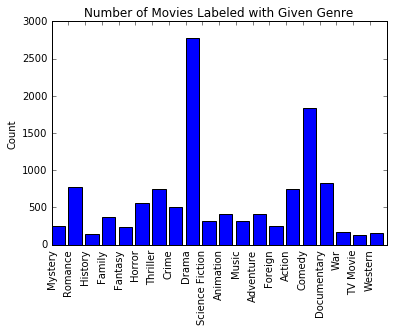

In [7]:
genres = list(unique_genres)
counts = [sum(i in c['genres'] for c in TMDB_dictionary.values()) for i in genres]
place_holder = range(len(genres))
                     
fig, axs = plt.subplots(1)
axs.bar(place_holder, counts)
plt.xticks(place_holder, genres)
axs.set_title("Number of Movies Labeled with Given Genre")
axs.set_ylabel('Count')

for label in axs.get_xmajorticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")

plt.show()

This histogram shows the relative popularity of movie genres. The most popular movie genre is Drama, followed by Comedy, Action, Romance, and Documentary.

<a id='section4a'><a\>

### Genre Pairs
Find top 25 pairs of genres that are most common and top 25 pairs of genres that are least common

In [8]:
genre_pairs = []
labels = []
for i in range(len(genres)):
    for j in range(i+1,len(genres)):
        labels.append(str(genres[i])+str(genres[j]))
        gen_1 = [genres[i] in c['genres'] for c in TMDB_dictionary.values()]
        gen_2 = [genres[j] in c['genres'] for c in TMDB_dictionary.values()]
        genre_pairs.append([genres[i],genres[j],sum(gen_1[l] == gen_2[l] == 1 for l in range(len(gen_2)))])
            

counts = [i[2] for i in genre_pairs]


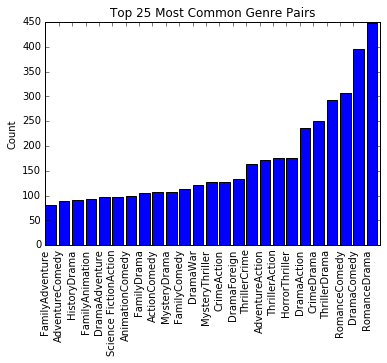

In [9]:
#find top 10
idx = np.argsort(counts)[-25:]
new_counts = [counts[i] for i in idx]
p = [labels[i] for i in idx]
place = range(len(p))
                     
fig, axs = plt.subplots(1)
axs.bar(place, new_counts)
plt.xticks(place, p)
axs.set_title("Top 25 Most Common Genre Pairs")
axs.set_ylabel('Count')

for label in axs.get_xmajorticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")

plt.show()

As the histogram shows, Romance and Drama are often linked, as well as Drama and Comedy and Romance and Comedy. 

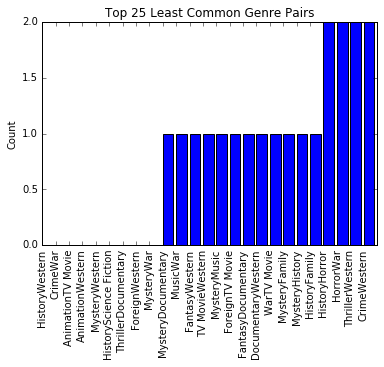

In [10]:
#find bottom 10
idx = np.argsort(counts)[:25]
new_counts = [counts[i] for i in idx]
p = [labels[i] for i in idx]
place = range(len(p))
                     
fig, axs = plt.subplots(1)
axs.bar(place, new_counts)
plt.xticks(place, p)
axs.set_title("Top 25 Least Common Genre Pairs")
axs.set_ylabel('Count')

for label in axs.get_xmajorticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")

plt.show()

The above histogram shows that pairs of genres that are unlikely include: Crime and War, Mystery and Western, History and Horror, etc. 

### Movie Genre Groups (Not just Pairs)

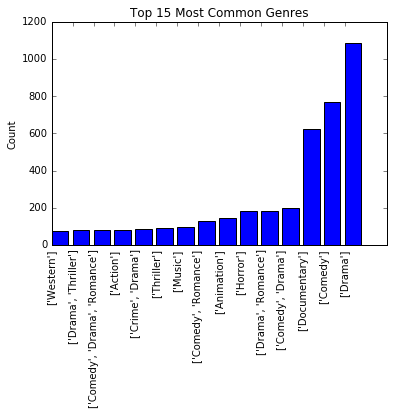

In [11]:
popularity_subset = []
revenue_subset = []
genres_subset = []
names_subset = []
colours = []

genre_ops = list(set([str(sorted(i['genres'])) for i in TMDB_dictionary.values()]))
genre_counts = [0]*len(genre_ops)

for c in TMDB_dictionary.values():
    rev = int(c['revenue'])
    pop = float(c['popularity'])
    gen = c['genres']
    title = c['title']
    genre_counts[genre_ops.index(str(sorted(gen)))] += 1
    
idx = np.argsort(genre_counts)
count = [genre_counts[i] for i in idx][-16:-1]
genres = [genre_ops[i] for i in idx][-16:-1]
place = range(len(count))

fig, axs = plt.subplots(1)
axs.bar(place, count)
plt.xticks(place, genres)
axs.set_title("Top 15 Most Common Genres")
axs.set_ylabel('Count')

for label in axs.get_xmajorticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("center")

plt.show()

The top 5 genres for our movie subset are: Drama, Comedy, Documentary, Comedy and Drama, and Drama and Romance. We also note here that the top genre was "" (but was excluded from the chart), this is important going foward as we'll have to exclude movies for which we have no genre information. 

### Consider Movie Popularity vs. Revenue and Genre Effect

For this part, we look at the relationship between movie popularity and revenue, and then consider whether genre plays a role in this relationship. Note that movies with 0 revenue or 0 popularity are discarded as these are incomplete records most likely. 

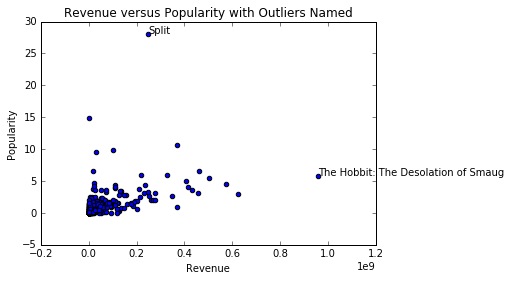

In [12]:
popularity = []
revenue = []
genres = []
names = []

for c in TMDB_dictionary.values():
    rev = int(c['revenue'])
    pop = float(c['popularity'])
    gen = c['genres']
    title = c['title']
    
    if rev != 0 and pop != 0:
        popularity.append(pop)
        revenue.append(rev)
        genres.append(gen)
        names.append(title)
    
fig, axs = plt.subplots(1)
axs.scatter(x = revenue, y = popularity)
axs.set_title("Revenue versus Popularity with Outliers Named")
axs.set_ylabel('Popularity')
axs.set_xlabel('Revenue')
for i in range(len(names)):
    if names[i] == 'Split' or names[i] == "The Hobbit: The Desolation of Smaug":
        axs.annotate(names[i].decode('utf-8'), (revenue[i],popularity[i]))
    else:
        axs.annotate("", (revenue[i],popularity[i]))

plt.show()

We see that Split and The Hobbit are both outiers. The Hobbit has a very high revenue, and Split has a very high popularity. Now we remove these outliers (and restrict our scale to < 10 popularity and < 0.4 1e9 revenue) so we can see genre trends in the rest of the data. 

In [13]:

def consider_pairs_genres(genre1, genre2):
    popularity_subset = []
    revenue_subset = []
    genres_subset = []
    names_subset = []
    colours = []
    for c in TMDB_dictionary.values():
        rev = int(c['revenue'])
        pop = float(c['popularity'])
        gen = c['genres']
        title = c['title']
    
        if rev > 0 and rev < 0.4*1e9 and pop > 0 and pop < 10:
            if genre1 in gen and genre2 in gen:
                popularity_subset.append(pop)
                revenue_subset.append(rev)
                genres_subset.append(genre1 +" and "+ genre2)
                names_subset.append(title)  
                colours.append('purple')
            elif genre1 in gen:
                popularity_subset.append(pop)
                revenue_subset.append(rev)
                genres_subset.append(genre1)
                names_subset.append(title)
                colours.append('r')
            elif genre2 in gen:
                popularity_subset.append(pop)
                revenue_subset.append(rev)
                genres_subset.append(genre2)
                names_subset.append(title)
                colours.append('b')
    
    for (i,cla) in enumerate(set(genres_subset)):
        xc = [p for (j,p) in enumerate(revenue_subset) if genres_subset[j] == cla]
        yc = [p for (j,p) in enumerate(popularity_subset) if genres_subset[j] == cla]
        colors = [c for (j,c) in enumerate(colours) if genres_subset[j] == cla]
        plt.scatter(x = xc, y = yc, c = colors, label = cla)
        
    plt.title("Revenue versus Popularity for Select Genres")
    plt.ylabel('Popularity')
    plt.xlabel('Revenue')
    plt.legend()
    plt.show()


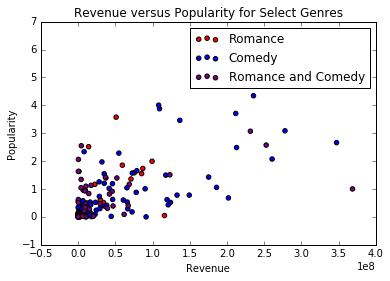

In [14]:
consider_pairs_genres('Romance', 'Comedy')

Note that Romance movies are colored red, Comedy movies are blue and movies that are both Romance and Comedies are purple. In general, we see that comedy movies or comedy/romance movies have a higher revenue than pure romance movies. Comedy movies also tend to have the highest popularity versus romance movies. 

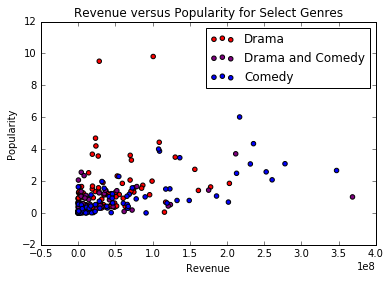

In [15]:
consider_pairs_genres('Drama', 'Comedy')

Drama movies have a higher popularity than comedies, and comedies have a higher revenue than dramas. 

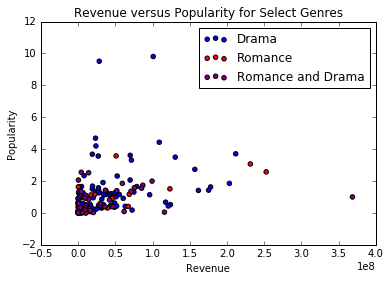

In [16]:
consider_pairs_genres('Romance', 'Drama')

Drama movies tend to have a higher popularity than Romance movies

## IMDb EDA

- See attached ipynb for code to generate dataset
- See attached pdf of Tableau Visualizations

See these links for interactive Tableau dashboards (as the dashboards don't show up in the pdf, just the python notebook)

https://public.tableau.com/views/eda_imdb/D1?:embed=y&:display_count=yes
https://public.tableau.com/views/eda_imdb/D2?:embed=y&:display_count=yes https://public.tableau.com/views/eda_imdb/D3?:embed=y&:display_count=yes https://public.tableau.com/views/eda_imdb/D4?:embed=y&:display_count=yes


### Please run the cells below to generate the embedded dashboards if you do not see them immediately

In [3]:
from IPython.core.display import HTML
HTML("<div class='tableauPlaceholder' id='viz1491406762182' style='position: relative'><noscript><a href='#'><img alt='Drama and comedy are the most popular genres.For the 2000-movie random sample we selected from IMDB, we decided to primarily look at genre by extracting 17 binary columns of genre categories that represent the (non-comprehensive) list of the 17 most com ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='eda_imdb&#47;D1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1491406762182');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1004px';vizElement.style.height='669px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")

In [2]:
from IPython.core.display import HTML
HTML("<div class='tableauPlaceholder' id='viz1491406933265' style='position: relative'><noscript><a href='#'><img alt='Interactive: Explore the prevalence of each genre over time ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D2&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='eda_imdb&#47;D2' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D2&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1491406933265');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1004px';vizElement.style.height='669px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")

In [3]:
from IPython.core.display import HTML
HTML("<div class='tableauPlaceholder' id='viz1491406982404' style='position: relative'><noscript><a href='#'><img alt='Interactive: Explore the distribution of ratings and votes for each genre ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D3&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='eda_imdb&#47;D3' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D3&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1491406982404');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1004px';vizElement.style.height='669px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")

In [5]:
from IPython.core.display import HTML
HTML("<div class='tableauPlaceholder' id='viz1491407009608' style='position: relative'><noscript><a href='#'><img alt='Exploring the genre that is returned first for each movie ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D4&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='site_root' value='' /><param name='name' value='eda_imdb&#47;D4' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;ed&#47;eda_imdb&#47;D4&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1491407009608');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='1004px';vizElement.style.height='669px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>")

<a id='section6'><a\>

# List of Questions We Want to Answer

1. How informative is movie popularity in terms of predicting movie genre?  
2. Which words in movie titles tend to correlate to certain genres?  
3. Is the average pixel color of a movie poster informative in terms of determining its genre? For instance if the average pixel color is red, maybe it is a Crime movie.  
4. Are movies with longer runtimes more or less popular and is there any correlation between runtime and genre?
5. Can movies be grouped together on the basis of textual information (like plot synopsis), and do these groups correlate with particular genres?

<a id='section7'><a\>

# Beginning Unsupervised Learning

### Clustering using KMeans on numerical attributes

In [57]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [41]:
numerical_attributes = np.array([np.array([float(movie["revenue"]), float(movie["popularity"]), 
                                           float(movie["vote_average"])]) for movie in TMDB_dictionary.values()])

In [52]:
est = KMeans(n_clusters=10)
est.fit(numerical_attributes)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

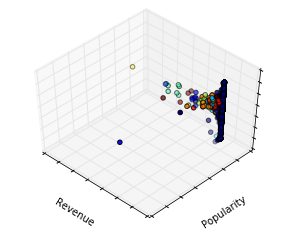

In [54]:
fig = plt.figure(figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
labels = est.labels_

ax.scatter(numerical_attributes[:, 0], numerical_attributes[:, 1], numerical_attributes[:, 2], c=labels.astype(np.float))

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Revenue')
ax.set_ylabel('Popularity')
ax.set_zlabel('Average Vote')

### Topic modeling using LDA on film synopses

This section examines whether films can be grouped into topics on the basis of their synopses. This allows us to perform clustering on non-numerical data. We can then examine the relationship between topic membership and genre membership.

In [90]:
import lda
from nltk.tokenize import RegexpTokenizer
from stop_words import get_stop_words
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import string
from itertools import chain

In [97]:
titles = [movie["title"] for movie in TMDB_dictionary.values()]
ids = [movie["id"] for movie in TMDB_dictionary.values()]
overviews = [movie["overview"] for movie in TMDB_dictionary.values()]

Remove stop words, and perform stemming and tokenizization for input to the LDA model.

In [80]:
tokenizer = RegexpTokenizer(r'\w+')
en_stop = get_stop_words('en')
p_stemmer = PorterStemmer()
printable = set(string.printable)

synopses = []
for synopsis in overviews:
    ascii = ''.join([char for char in synopsis if char in printable])
    tokens = tokenizer.tokenize(ascii.lower())
    stopped_tokens = [i for i in tokens if not i in en_stop]
    stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    synopses.append(stemmed_tokens)

In [81]:
dictionary = corpora.Dictionary(synopses)
corpus = [dictionary.doc2bow(text) for text in synopses]

In [85]:
# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=5, minimum_probability=0)

Now we can examine the clusters of words identified as topics in the LDA model:

In [86]:
for top in ldamodel.print_topics():
    print top

(0, u'0.019*"s" + 0.011*"film" + 0.008*"year" + 0.007*"new" + 0.006*"time" + 0.006*"show" + 0.006*"live" + 0.005*"documentari" + 0.004*"video" + 0.004*"footag"')
(1, u'0.018*"film" + 0.006*"documentari" + 0.005*"short" + 0.005*"touch" + 0.005*"music" + 0.005*"oscar" + 0.004*"star" + 0.004*"artist" + 0.004*"also" + 0.004*"fiction"')
(2, u'0.033*"de" + 0.014*"la" + 0.010*"le" + 0.007*"l" + 0.006*"d" + 0.005*"o" + 0.005*"dan" + 0.005*"en" + 0.004*"et" + 0.004*"transport"')
(3, u'0.014*"villag" + 0.010*"love" + 0.010*"s" + 0.008*"friend" + 0.006*"town" + 0.006*"old" + 0.006*"life" + 0.006*"get" + 0.006*"fall" + 0.006*"peopl"')
(4, u'0.022*"match" + 0.015*"championship" + 0.010*"event" + 0.009*"team" + 0.008*"cat" + 0.007*"vs" + 0.007*"took" + 0.007*"place" + 0.007*"defend" + 0.006*"amp"')
(5, u'0.009*"s" + 0.008*"one" + 0.007*"human" + 0.006*"polit" + 0.006*"world" + 0.005*"earth" + 0.005*"film" + 0.004*"planet" + 0.004*"year" + 0.004*"engin"')
(6, u'0.013*"s" + 0.012*"war" + 0.011*"love" 

We can now examine the relationship between membership in a particular cluster and genre, by assigning each movie to its most representative topic, and then examining the genres in each cluster. We'll do this for a couple of the clusters (topics 5 and 10) below.

In [88]:
lda_corpus = ldamodel[corpus]

In [91]:
scores = list(chain(*[[score for topic_id,score in topic] 
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)
print threshold

0.05


In [142]:
cluster1 = [j for i,j in zip(lda_corpus,ids) if i[5][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,ids) if i[10][1] > threshold]

<a id='section7'><a\>

In [143]:
genres1 = {}
for Id in cluster1:
    movie = TMDB_dictionary[Id]
    g = movie['genres']
    for genre in g:
        if genre not in genres1:
            genres1[genre] = 1
        else: genres1[genre] += 1
            
genres2 = {}
for Id in cluster2:
    movie = TMDB_dictionary[Id]
    g = movie['genres']
    for genre in g:
        if genre not in genres2:
            genres2[genre] = 1
        else: genres2[genre] += 1            

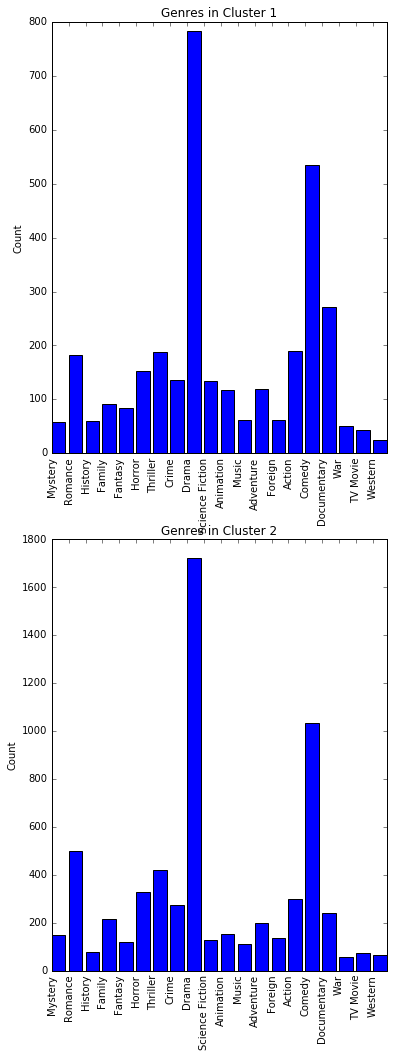

In [144]:
fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(17)
ax1.set_xticks(range(len(genres1.keys())))
ax1.set_xticklabels(genres1.keys(), rotation=90)
ax1.bar(range(len(genres1)), genres1.values())
ax1.set_title("Genres in Cluster 1")
ax1.set_ylabel('Count')
ax2.set_xticks(range(len(genres2.keys())))
ax2.set_xticklabels(genres2.keys(), rotation=90)
ax2.bar(range(len(genres2)), genres2.values())
ax2.set_title("Genres in Cluster 2")
ax2.set_ylabel('Count')

We can see that topics assigned on the basis of synopsis information alone are not particularly good at discriminating between genres. Because of the sheer volume of Drama and Comedy movies, each cluster appears to fall predominantly into these categories. Both of these distributions look quite similar to the distribution of genres across the entire dataset shown in the EDA section above.

<a id='section8'><a\>

# Beginning Supervised Learning

This part of the code looks into the question of whether a movie title is a good predictor of the movie's genre using the bag of words method. The bag of words methdo we use ignores the stop words. We consider two models: Multinomial Naive Bayes and an SVM. All these models are trained separately for each of the 20 different genre types- i.e one model predicts Romance vs. non-romance, the next predicts Comedy vs. non-Comedy, etc. For the SVM model we used PCA and retained 10 components to train our model on. 

Accuracy of the classification is determined on the hold out (20% of data) test-set and reported below for each genre

In [169]:
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from sklearn.decomposition import SparsePCA
sw = stopwords.words('english')

words = []
genre_ops = set()
for i in TMDB_dictionary.values():
    word_list = i['title']
    words.append(word_list)
    for j in i['genres']:
        genre_ops.add(j)
genre_ops = list(genre_ops)   
    
vectorizer = CountVectorizer(stop_words = 'english', max_features = 100)
data_features = vectorizer.fit_transform(words)

In [126]:
#makes the response variable matrix with one-hot encoding of genre type
labels = [] 
for i in TMDB_dictionary.values():
    curr = []
    for j in genre_ops:
        if j in i['genres']:
            curr.append(1)
        else:
            curr.append(0)
    labels.append(curr)
    
labels = np.matrix(labels)

In [160]:
#split the data into train and test sets

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_features, labels, test_size = 0.20)

### Navie Bayes Model

In [166]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

def NB_genre(genre_type, X_train, X_test, y_test, y_train):
    labels_final  = []
    for row in y_train:
        labels_final.append(float(np.asarray(row)[0][genre_type]))

    clf = MultinomialNB()
    clf.fit(X_train,labels_final)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test[:,genre_type],y_pred)

In [167]:
for i in range(20):
    print genre_ops[i],"Accuracy:",NB_genre(i, X_train, X_test, y_test, y_train)

Mystery Accuracy: 0.971915747242
Romance Accuracy: 0.920762286861
History Accuracy: 0.986459378134
Family Accuracy: 0.966900702106
Fantasy Accuracy: 0.978435305918
Horror Accuracy: 0.945336008024
Thriller Accuracy: 0.913741223671
Crime Accuracy: 0.945336008024
Drama Accuracy: 0.727181544634
Science Fiction Accuracy: 0.96740220662
Animation Accuracy: 0.956870611836
Music Accuracy: 0.962387161484
Adventure Accuracy: 0.961384152457
Foreign Accuracy: 0.970411233701
Action Accuracy: 0.915747241725
Comedy Accuracy: 0.819458375125
Documentary Accuracy: 0.906218655968
War Accuracy: 0.983951855567
TV Movie Accuracy: 0.983450351053
Western Accuracy: 0.986960882648


### SVM model

In [128]:
from sklearn.svm import SVC

def svm_genre(genre_type, X_train, X_test, y_test, y_train):
    labels_final  = []
    for row in y_train:
        labels_final.append(float(np.asarray(row)[0][genre_type]))

    model = SVC()
    model.fit(X_train, labels_final)
    y_pred = model.predict(X_test)
    return accuracy_score(y_test[:,genre_type],y_pred)

In [129]:
#here we perform PCA and keep the top 10 components 
pca = SparsePCA(n_components = 10)
X_train_SVM = pca.fit_transform(X_train.toarray())
X_test_SVM = pca.transform(X_test.toarray())

for i in range(20):
    print genre_ops[i],"Accuracy:",svm_genre(i, X_train_SVM, X_test_SVM, y_test, y_train)

Mystery Accuracy: 0.973921765296
Romance Accuracy: 0.925777331996
History Accuracy: 0.985456369107
Family Accuracy: 0.96038114343
Fantasy Accuracy: 0.976930792377
Horror Accuracy: 0.949348044132
Thriller Accuracy: 0.921263791374
Crime Accuracy: 0.947342026078
Drama Accuracy: 0.723671013039
Science Fiction Accuracy: 0.966900702106
Animation Accuracy: 0.955867602808
Music Accuracy: 0.969909729188
Adventure Accuracy: 0.950852557673
Foreign Accuracy: 0.977432296891
Action Accuracy: 0.923269809428
Comedy Accuracy: 0.816449348044
Documentary Accuracy: 0.925275827482
War Accuracy: 0.975426278837
TV Movie Accuracy: 0.985957873621
Western Accuracy: 0.984954864594
